# Исследование поведения пользователей сервиса аренды самокатов

Переданны данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.\
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* **без подписки**

абонентская плата отсутствует\
стоимость одной минуты поездки — 8 рублей\
стоимость старта (начала поездки) — 50 рублей
* **с подпиской Ultra**

абонентская плата — 199 рублей в месяц\
стоимость одной минуты поездки — 6 рублей\
стоимость старта — бесплатно


В основных данных есть информация о пользователях, их поездках и подписках.
* Пользователи — **users_go.csv**

**user_id** - уникальный идентификатор пользователя\
**name** - имя пользователя\
**age** - возраст\
**city** - город\
**subscription_type** -	тип подписки (free, ultra)

* Поездки — **rides_go.csv**

**user_id**	- уникальный идентификатор пользователя\
**distance** - расстояние, которое пользователь проехал в текущей сессии (в метрах)\
**duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»\
**date** - дата совершения поездки

* Подписки — **subscriptions_go.csv**

**subscription_type** - тип подписки\
**minute_price** - стоимость одной минуты поездки по данной подписке\
**start_ride_price** - стоимость начала поездки\
**subscription_fee** - стоимость ежемесячного платежа

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
sns.set()

In [2]:
from math import factorial
from scipy.stats import binom
from math import sqrt
from datetime import datetime

In [3]:
# Загрузка данных из CSV-файлов
try:
    users, rides, subscriptions = (
    pd.read_csv('/datasets/users_go.csv'),
    pd.read_csv('/datasets/rides_go.csv', parse_dates=['date']),
    pd.read_csv('/datasets/subscriptions_go.csv')
    )
except:
    users, rides, subscriptions = (
    pd.read_csv(r'C:\Users\tarko\OneDrive\Рабочий стол\Анализ данных\Проекты\users_go.csv'),
    pd.read_csv(r'C:\Users\tarko\OneDrive\Рабочий стол\Анализ данных\Проекты\rides_go.csv', parse_dates=['date']),
    pd.read_csv(r'C:\Users\tarko\OneDrive\Рабочий стол\Анализ данных\Проекты\subscriptions_go.csv')
    )

In [4]:
display(users.head(10))
users.info()
display(rides.head(10))
rides.info()
display(subscriptions.head())
subscriptions.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


**Вывод** Исходя из общей информации по трем датафреймам, можно сказать следующее:

* **users** состоит из 5 колонок и 1565 строк. Все колонки и строки заполнены и имеют правильный тип данных
* **rides** состоит из 4 колонок и 18068 строк.  Все колонки и строки заполнены и имеют правильный тип данных
* **subscriptions** состоит из 4 колонок и 2 строк. Все колонки и строки заполнены и имеют правильный тип данных

## Предобработка данных

In [5]:
# проверяем за какой период у нас данные
rides['date'].dt.year.value_counts()

2021    18068
Name: date, dtype: int64

Из результата видно, что все 18068 строк в датафреймеза период 2021 года. Следовательно данные за несколько лет при агрегации по месяцам не склеятся.

In [6]:
#создаем новый столбец с номером месяца на основе столбца date
rides['month'] = rides['date'].dt.month

# округляем значения столбца distance до 2 знаков после запятой
rides['distance'] = round(rides['distance'] , 2)

In [7]:
# ищем выбивающиеся значения
rides['duration'].sort_values().unique()

array([ 0.5       ,  2.03563247,  2.05325125, ..., 39.52660212,
       39.87385602, 40.82396262])

Исходя из результата, делаю вывод, что аномалий в датафрейме нет. Значения меньше 5 минут могут означать, что пользовотель после активации аренды передумал продолжать поездку, либо достиг точки назначения.

In [8]:
# проверяем наличие пропущенных значений в users
print(users.isnull().sum(),'\n')
# смотрим долю пропусков каждого датафрейма
display(pd.DataFrame(round(users.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm'))

# проверяем наличие пропущенных значений в rides
print(rides.isnull().sum(),'\n')
# смотрим долю пропусков каждого датафрейма
display(pd.DataFrame(round(rides.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm'))

# проверяем наличие пропущенных значений в subscriptions
print(subscriptions.isnull().sum(),'\n')
# смотрим долю пропусков каждого датафрейма
display(pd.DataFrame(round(subscriptions.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm'))


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64 



,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000


user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64 



,0
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000


subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64 



,0
subscription_type,0.000000
minute_price,0.000000
start_ride_price,0.000000
subscription_fee,0.000000


Пропуски в 3-х датафреймах отсутствуют

In [9]:
# проверяем наличие дубликатов в датафреймах
print('Число дубликатов users:', users.duplicated().sum(),'\n')
print('Число дубликатов rides:', rides.duplicated().sum(),'\n')
print('Число дубликатов subscriptions:', subscriptions.duplicated().sum(),'\n')

Число дубликатов users: 31 

Число дубликатов rides: 0 

Число дубликатов subscriptions: 0 



В датафрейме **users** имеется 31 дубликат

In [10]:
# удаляем явные дубликаты
users = users.drop_duplicates()

# проверяем наличие дубликатов в датафреймe users
print('Число дубликатов users:', users.duplicated().sum(),'\n')

Число дубликатов users: 0 



**Вывод**

В процессе обработки данных не было выявлено пропусков данных, но были выявленны явные дубликаты в датафрейме **'users'**, которые были удалены. А также провели следующие итерации:
* Выявили, что данные представлены за 2021 год. Следовательно, данные за несколько лет не склеятся при агрегации по месяцам.
    
* Округлили расстояния в `rides['distance']`
    
* Проверили отсутствие аномалий в `rides['duration']`
    

## Исследовательский анализ данных

### Частота встречаемости городов

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


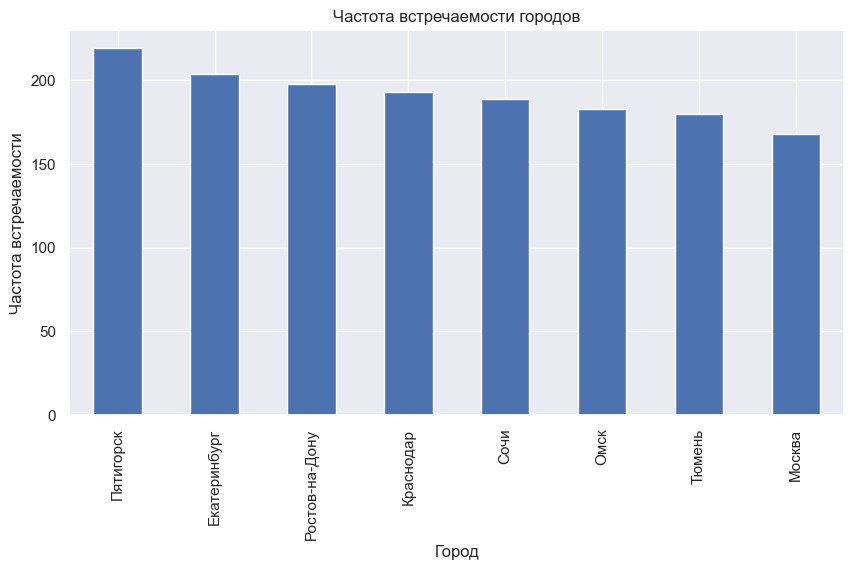

In [11]:
print(users['city'].value_counts())
users['city'].value_counts().plot(kind='bar', figsize=(10,5))
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Частота встречаемости')
plt.show()

**Вывод**

Исходя из анализа видно, что наиболее активно сервисом пользуются в Пятигорске более 200 пользователей. Наименьший показатель в Москве - 168 пользователя.

### Соотношение пользователей с подпиской и без подписки

free     0.544329
ultra    0.455671
Name: subscription_type, dtype: float64


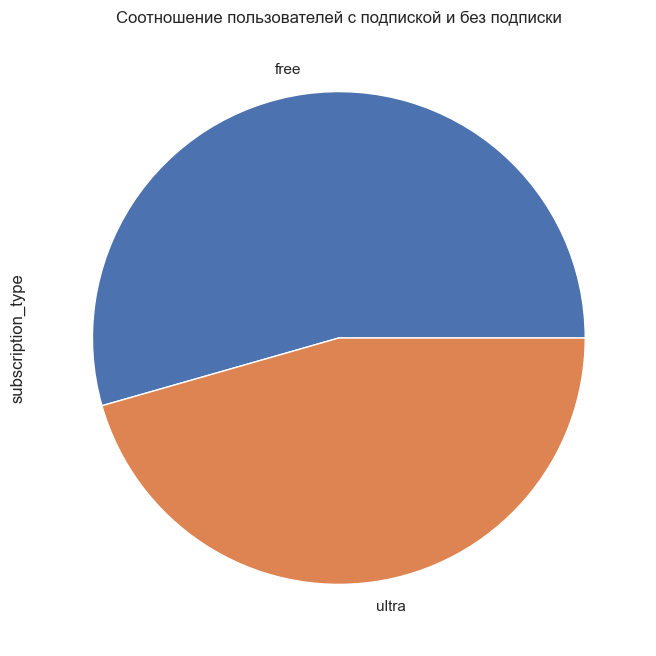

In [12]:
subscription_counts = users['subscription_type'].value_counts()
subscription_ratio = subscription_counts / len(users)
print(subscription_ratio)
subscription_ratio.plot(kind='pie', figsize=(8,8))
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

**Вывод**

Из графика видно, что доля пользователей без подписки (free)  по отношению к пользователям с подпиской (ultra) выше на 9%.

### Возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64 



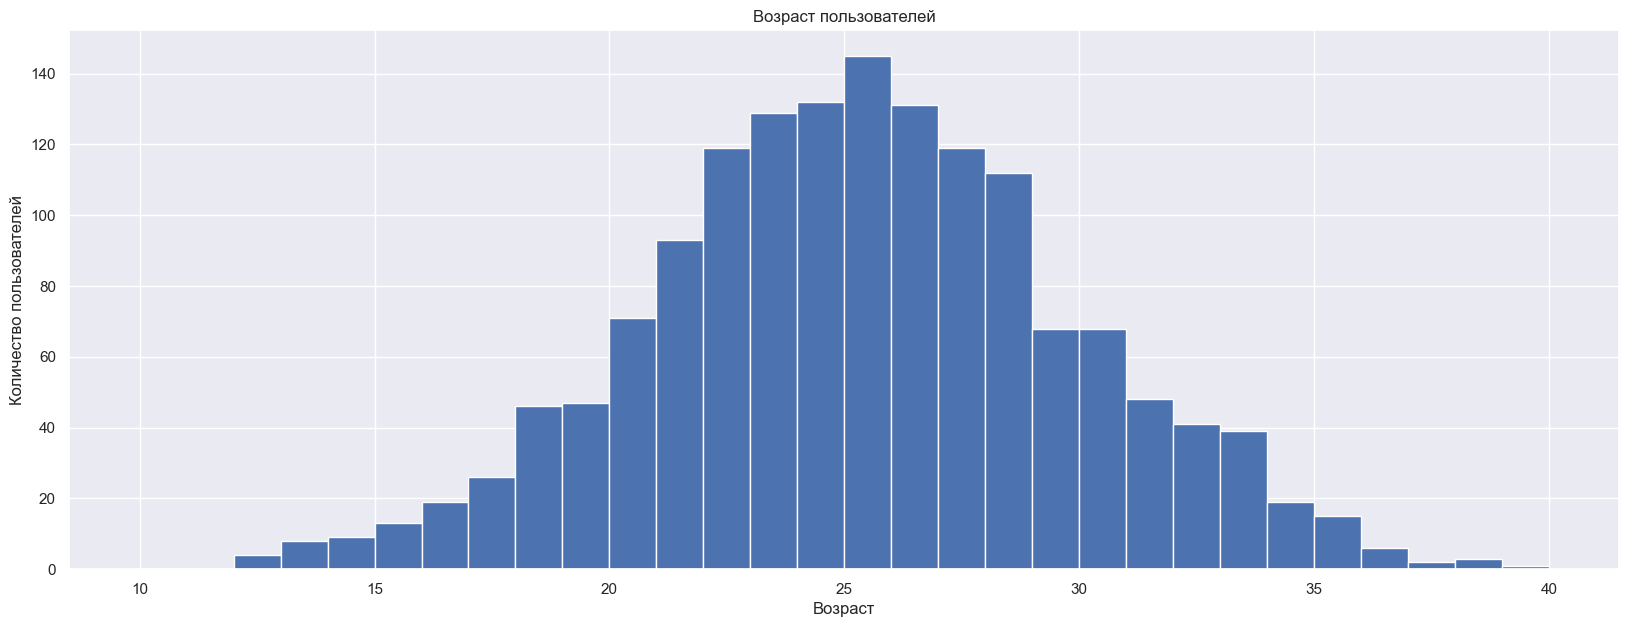

In [13]:
print(users['age'].describe(), '\n')
users['age'].plot(kind='hist', bins=30,  figsize=(20,7), range=(10,40), grid=True)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

**Вывод**

Из анализа видно следующее:
* 25% пользователей сервиса возрастом около 22 лет
* 50% пользователей сервиса возрастом около 25 лет
* 75% пользователей сервиса возрастом около 28 лет
* Средний возраст пользователей около 25 лет

### Расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64 



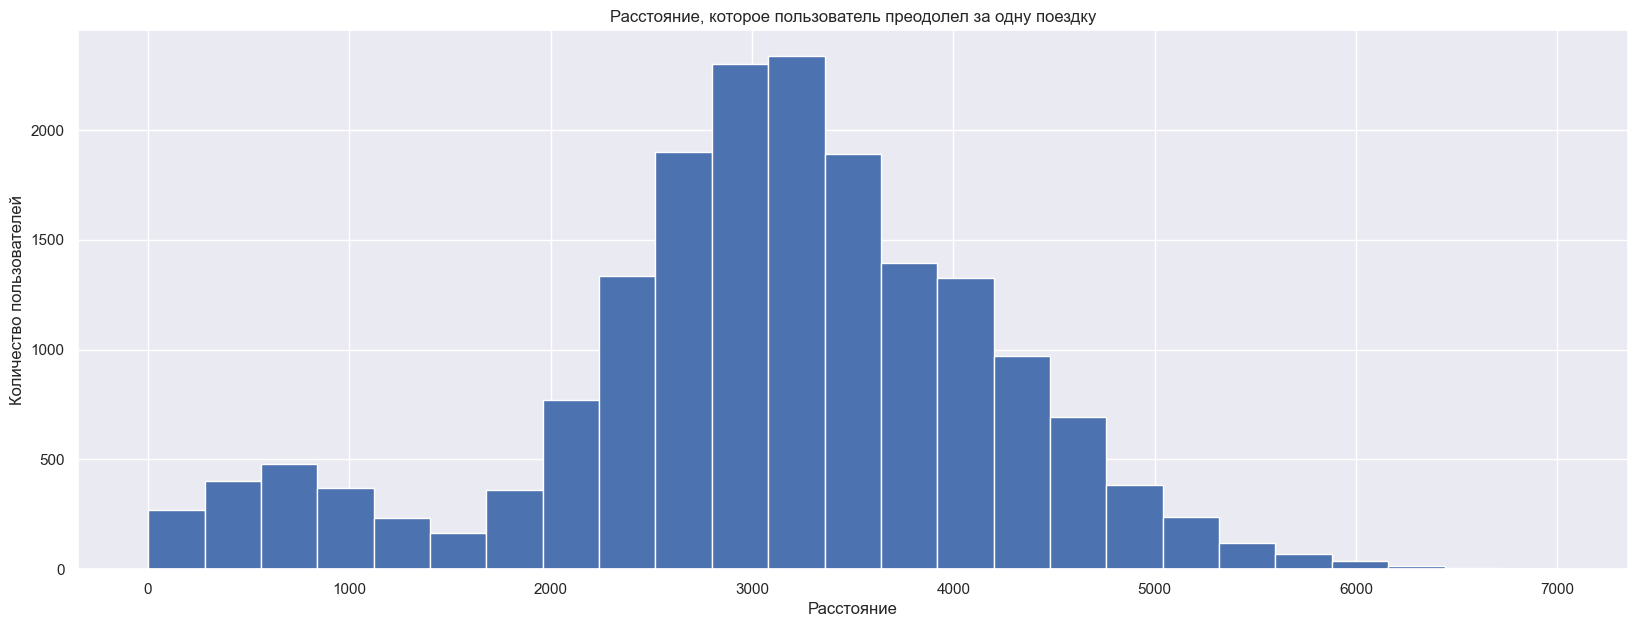

In [14]:
print(rides['distance'].describe(), '\n')
rides['distance'].plot(kind='hist', bins=25,  figsize=(20,7), range=(1,7000), grid=True)
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')
plt.show()

**Вывод**

Из анализа видно следующее:
* 25% пользователей сервиса проезжают около 2543 метров
* 50% пользователей сервиса проезжают около 3133 метров
* 75% пользователей сервиса проезжают около 3776 метров
* Среднее расстояние, которое проезжает пользователь 3070 метров


### Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64 



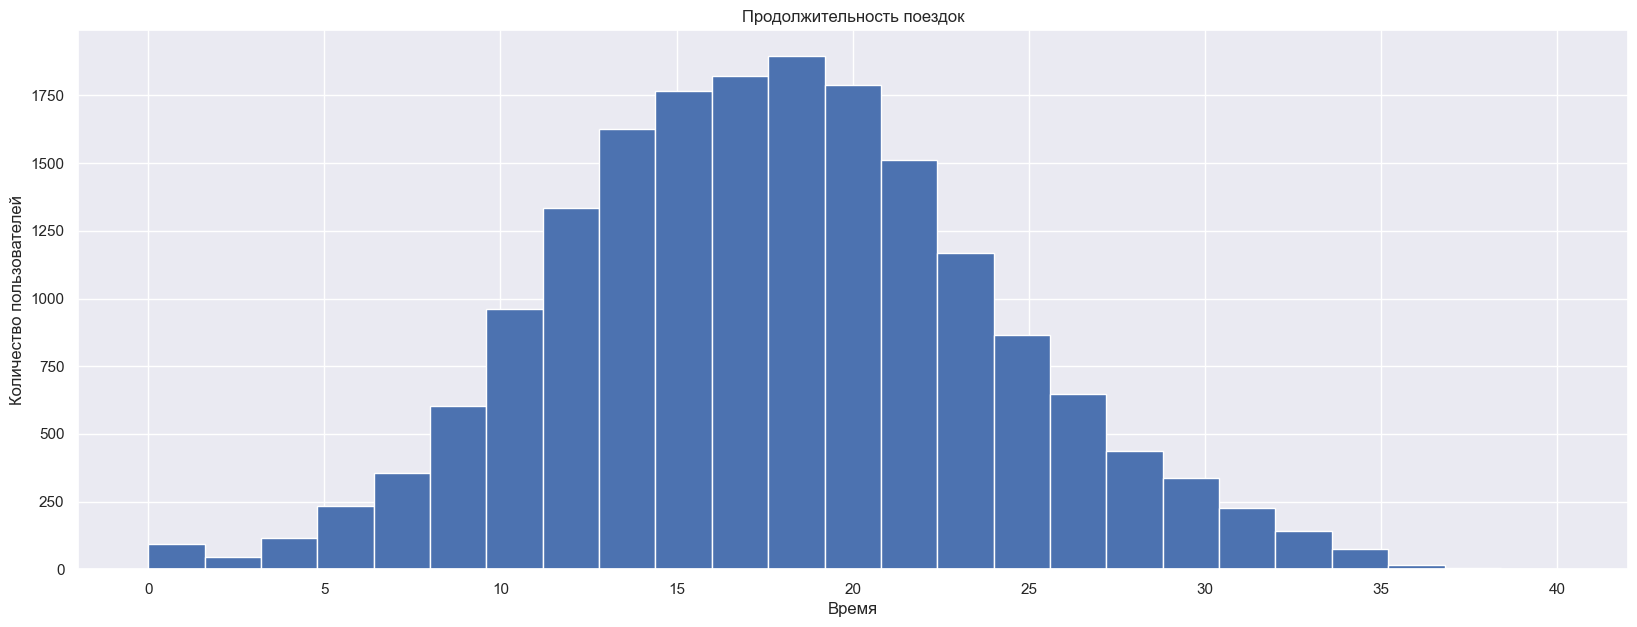

In [15]:
print(rides['duration'].describe(), '\n')
rides['duration'].plot(kind='hist', bins=25,  figsize=(20,7), range=(0,40), grid=True)
plt.title('Продолжительность поездок')
plt.xlabel('Время')
plt.ylabel('Количество пользователей')
plt.show()

rides['duration'] = np.ceil(rides['duration']) # каждое значение из столбца duration округляется с помощью «потолка»

**Вывод**

Из анализа видно следующее:
* у 25% пользователей сервиса продолжительность поездки занимает около 13 минут
* у 50% пользователей сервиса продолжительность поездки занимает около 17 минут
* у 75% пользователей сервиса продолжительность поездки занимает около 21 минут
* Средняя продолжительность поездки пользователей около 17 минут

## Объединение данных

In [16]:
# Объединяем данные о пользователях, поездках и подписках в один датафрейм.
merged_data = users.merge(rides, on='user_id', how='outer')
merged_data = merged_data.merge(subscriptions, on='subscription_type', how='outer')

display(merged_data.head(10))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27.0,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.89,17.0,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.02,15.0,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.12,24.0,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.69,16.0,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.69,16.0,2021-11-22,11,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27.0,2021-08-28,8,6,0,199


count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64 



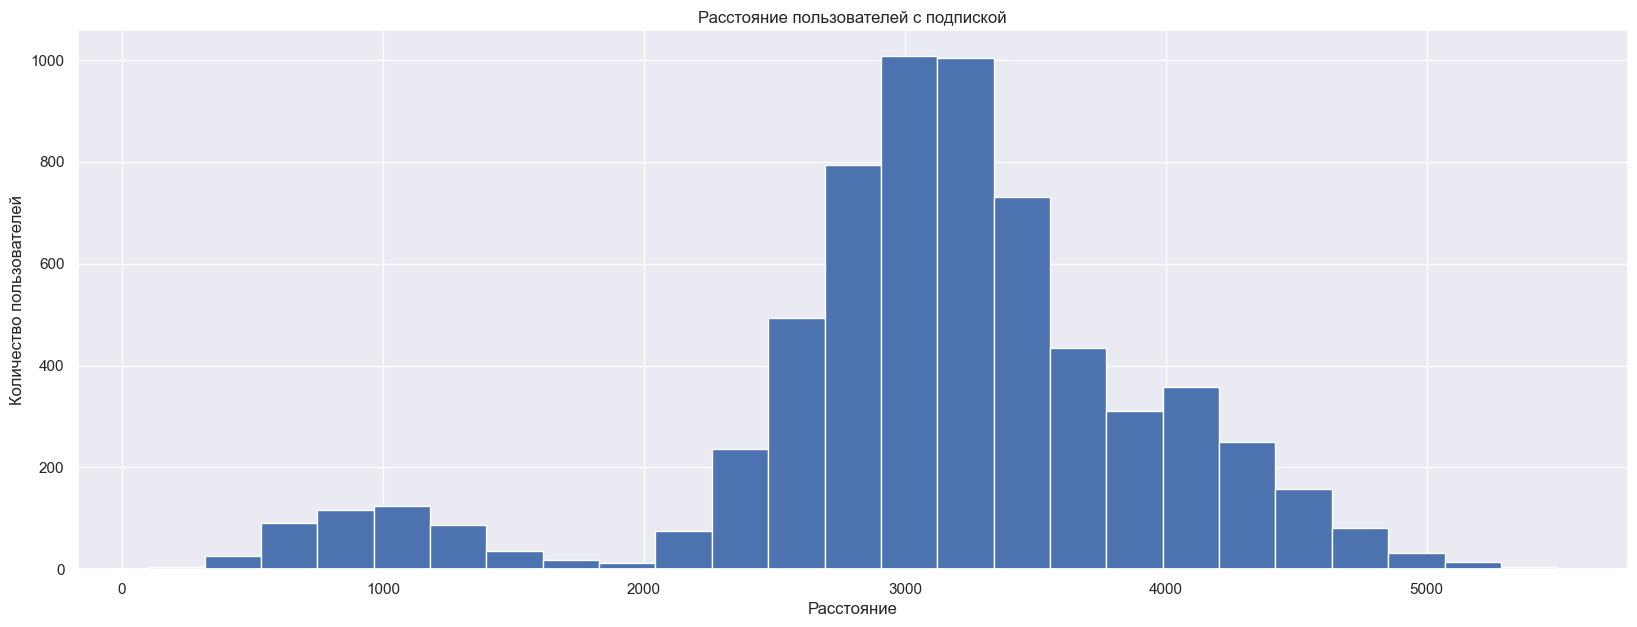

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64 



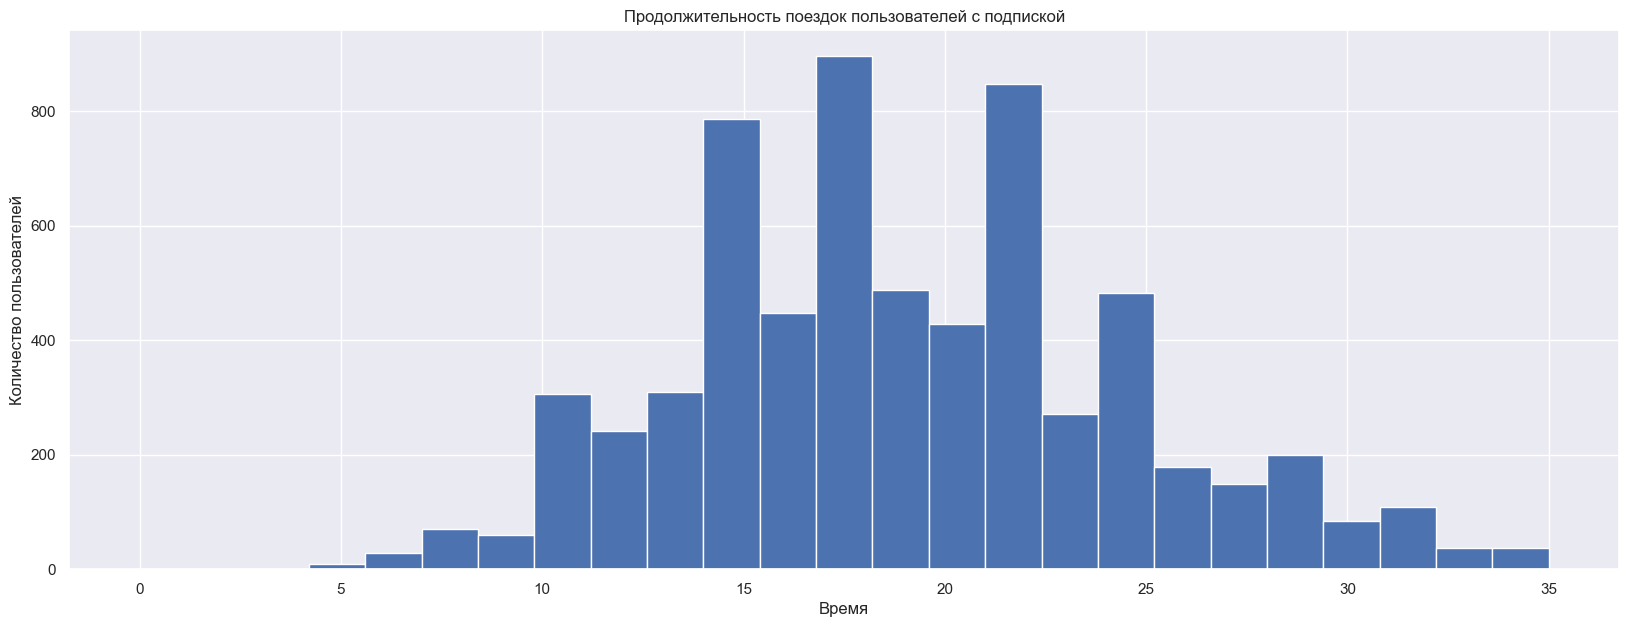

In [17]:
# Создаем датафрейм c данными о пользователях с подпиской
df_ultra = merged_data.query('subscription_type =="ultra"')
display(df_ultra.head())

print(df_ultra['distance'].describe(), '\n')
ax = df_ultra['distance'].plot(kind='hist', bins=25,  figsize=(20,7), range=(100,5500), grid=True)
plt.title('Расстояние пользователей с подпиской')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')
plt.show()

print(df_ultra['duration'].describe(), '\n')
ax = df_ultra['duration'].plot(kind='hist', bins=25,  figsize=(20,7), range=(0,35), grid=True)
plt.title('Продолжительность поездок пользователей с подпиской')
plt.xlabel('Время')
plt.ylabel('Количество пользователей')
plt.show()

Из анализа **df_ultra** видно следующее:
* 25% пользователей сервиса с подпиской проезжают около 2785 метров
* 50% пользователей сервиса с подпиской проезжают около 3148 метров
* 75% пользователей сервиса с подпиской проезжают около 3560 метров
* Среднее расстояние, которое проезжает пользователь с подпиской 3115 метров


* у 25% пользователей сервиса с подпиской продолжительность поездки занимает около 15 минут
* у 50% пользователей сервиса с подпиской продолжительность поездки занимает около 19 минут
* у 75% пользователей сервиса с подпиской продолжительность поездки занимает около 22 минут
* Средняя продолжительность поездки пользователей с подпиской около 19 минут

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,18.0,2021-02-14,2,8,50,0


count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64 



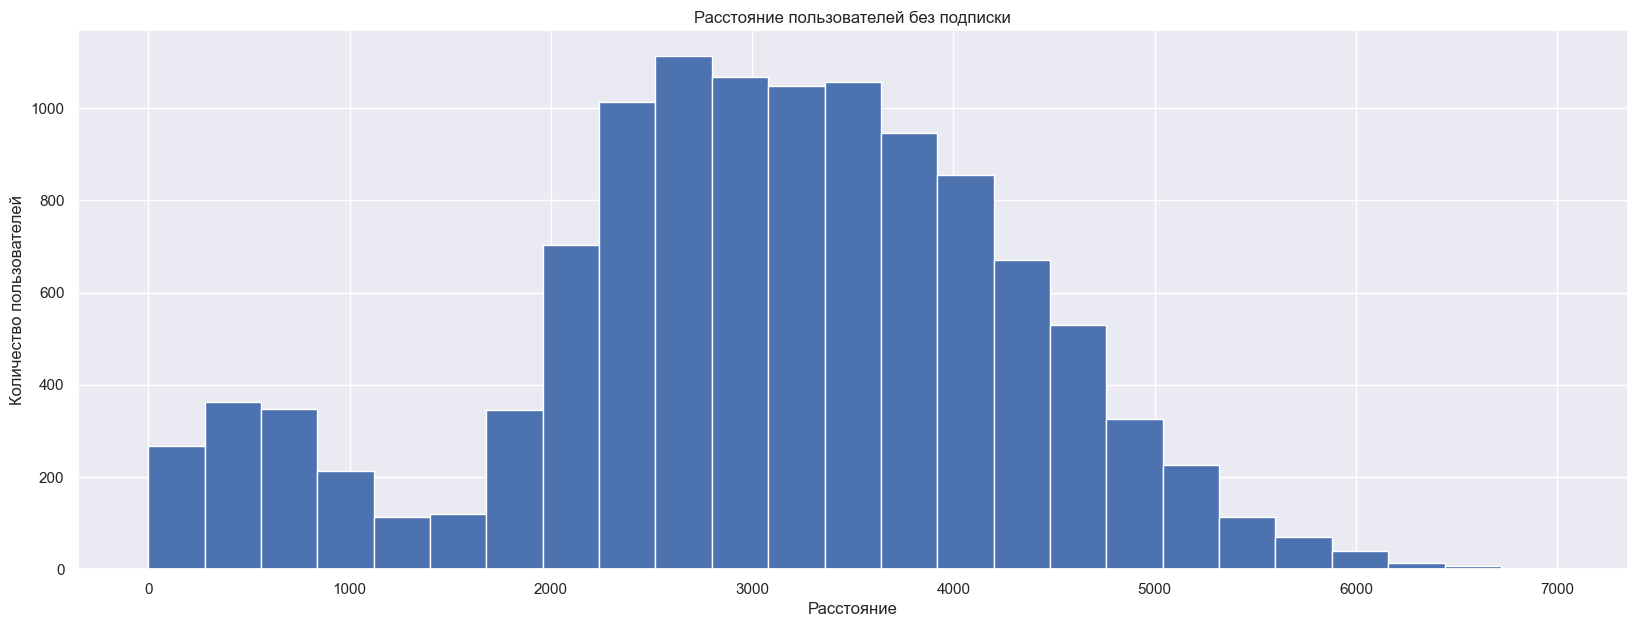

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64 



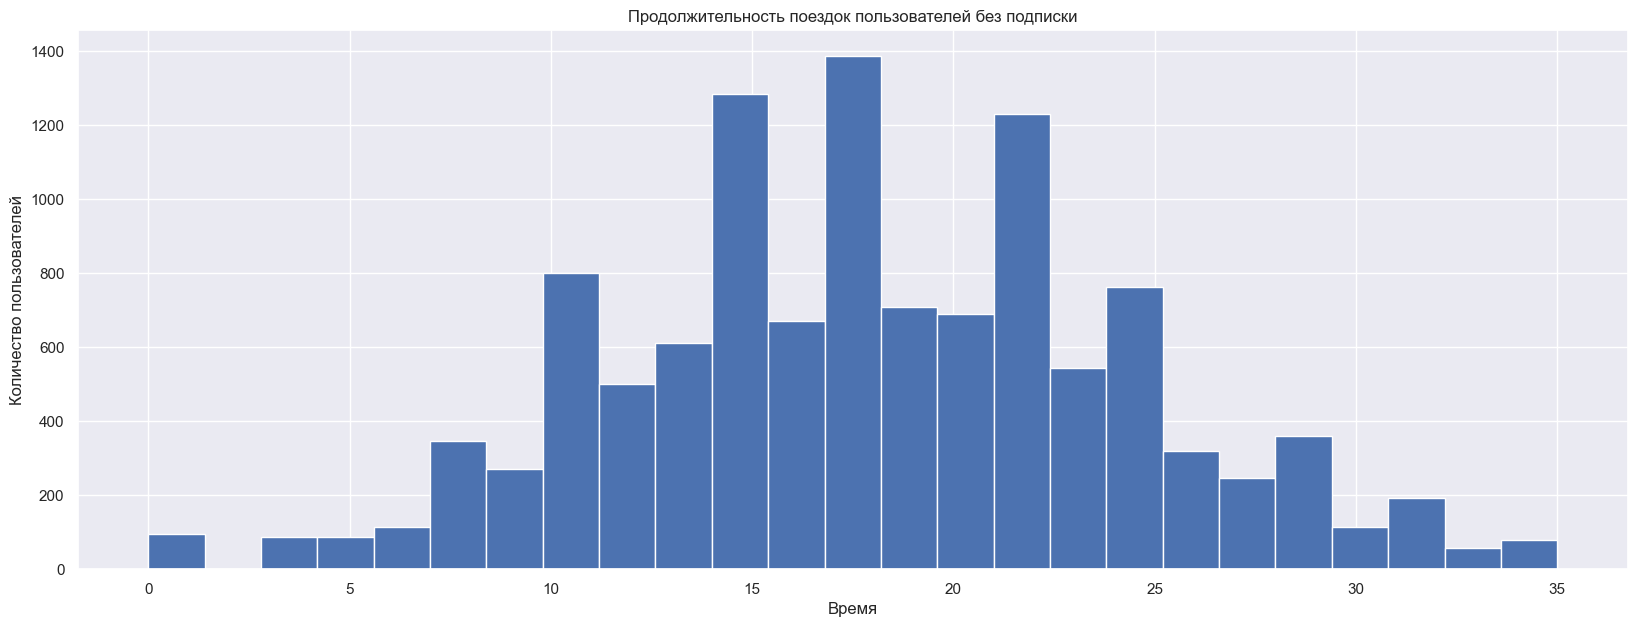

In [18]:
# Создаем датафрейм c данными о пользователях без подписки
df_free = merged_data.query('subscription_type =="free"')
display(df_free.head())

print(df_free['distance'].describe(), '\n')
df_free['distance'].plot(kind='hist', bins=25,  figsize=(20,7), range=(0,7000), grid=True)
plt.title('Расстояние пользователей без подписки')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')
plt.show()

print(df_free['duration'].describe(), '\n')
df_free['duration'].plot(kind='hist', bins=25,  figsize=(20,7), range=(0,35), grid=True)
plt.title('Продолжительность поездок пользователей без подписки')
plt.xlabel('Время')
plt.ylabel('Количество пользователей')
plt.show()

Из анализа **df_free** видно следующее:
* 25% пользователей сервиса без подписки проезжают около 2366 метров
* 50% пользователей сервиса без подписки проезжают около 3114 метров
* 75% пользователей сервиса без подписки проезжают около 3905 метров
* Среднее расстояние, которое проезжает пользователь без подписки 3045 метров


* у 25% пользователей сервиса без подписки продолжительность поездки занимает около 13 минут
* у 50% пользователей сервиса без подписки продолжительность поездки занимает около 18 минут
* у 75% пользователей сервиса без подписки продолжительность поездки занимает около 22 минут
* Средняя продолжительность поездки пользователей без подписки около 17.8 минут

Объединяем графики распределений для более наглядного результата

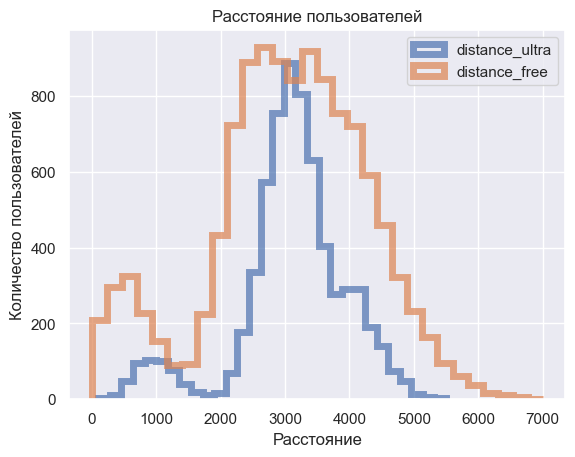

In [19]:
ax = df_ultra.plot(kind='hist', y='distance', histtype='step', bins=30, range=(100,5500), linewidth=5, alpha=0.7, label='distance_ultra')

df_free.plot(kind='hist', y='distance', histtype='step', bins=30, range=(0,7000), linewidth=5, alpha=0.7, label='distance_free',
                         ax=ax, grid=True, legend=True)
plt.title('Расстояние пользователей')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')
plt.show()

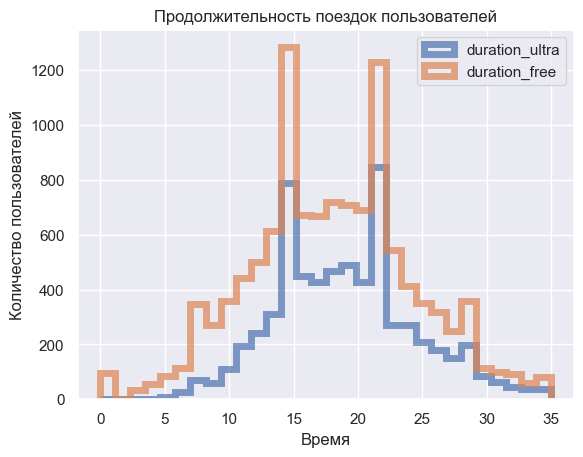

In [20]:
ax = df_ultra.plot(kind='hist', y='duration', histtype='step', bins=30, range=(0,35), linewidth=5, alpha=0.7, label='duration_ultra')

df_free.plot(kind='hist', y='duration', histtype='step', bins=30, range=(0,35), linewidth=5, alpha=0.7, label='duration_free',
                         ax=ax, grid=True, legend=True)
plt.title('Продолжительность поездок пользователей')
plt.xlabel('Время')
plt.ylabel('Количество пользователей')
plt.show()

**Вывод**

Исходя  из анализа расстояния и продолжительности поездок пользователей с подпиской и без подписки, можно сказать:

* пользователи без подписки проезжают меньшее расстояние, чем пользователи с подпиской
* у пользователей без подписки продолжительность поездки меньше, чем у пользователей с подпиской


## Подсчёт выручки

In [21]:
# Группировка данных по пользователю и месяцу, а затем агрегация по сумме для расстояния, количеству поездок и времени
agg_df = merged_data.groupby(['user_id', 'month'])[['distance', 'duration']].sum().reset_index()
agg_df.rename(columns={'distance': 'total_distance', 'duration': 'total_duration'}, inplace=True)

# проверяем наличие пропущенных значений в agg_df
print(agg_df.isnull().sum(),'\n')
# смотрим долю пропусков
display(pd.DataFrame(round(agg_df.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm'))

user_id           0
month             0
total_distance    0
total_duration    0
dtype: int64 



,0
user_id,0.000000
month,0.000000
total_distance,0.000000
total_duration,0.000000


Пропуски отсутствуют

In [22]:
# Добавление столбца с количеством поездок, считаемых с помощью метода 'size'
agg_df['total_trips'] = merged_data.groupby(['user_id', 'month']).size().reset_index(name='total_trips')['total_trips']

agg_df['total_price_month'] = ((merged_data['start_ride_price']*agg_df['total_trips'])+merged_data['minute_price']*agg_df['total_duration'])+merged_data['subscription_fee']

agg_df['subscription_type'] = merged_data['subscription_type']

# Вывод полученного датафрейма
display(agg_df)

,user_id,month,total_distance,total_duration,total_trips,total_price_month,subscription_type
0,1,1,7027.51,42.0,2,451.0,ultra
1,1,4,754.16,7.0,1,241.0,ultra
2,1,8,6723.47,46.0,2,475.0,ultra
3,1,10,5809.91,32.0,2,391.0,ultra
4,1,11,7003.50,56.0,3,535.0,ultra
...,...,...,...,...,...,...,...
11326,1534,6,3409.47,26.0,2,308.0,free
11327,1534,8,7622.45,48.0,2,484.0,free
11328,1534,9,4928.17,23.0,1,234.0,free
11329,1534,11,13350.02,78.0,4,824.0,free


Общая выручка сервиса за 2021 год: 3982632.0


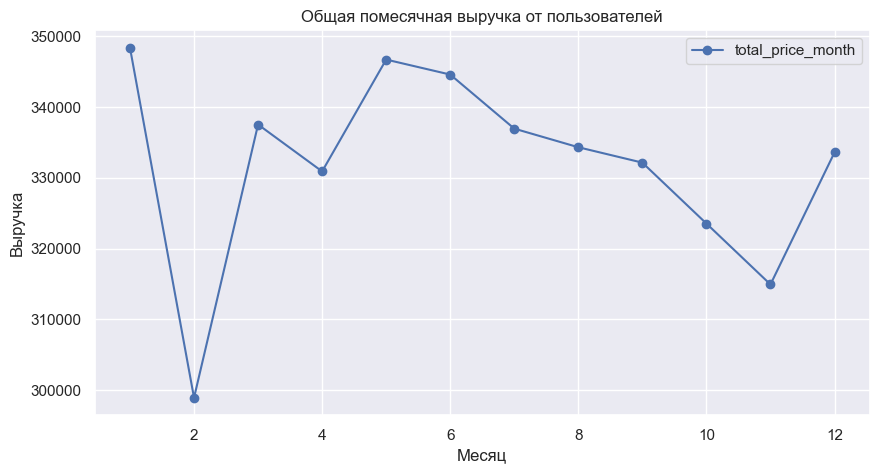

In [23]:
# Считаем общуую выручку за 2021 год
print('Общая выручка сервиса за 2021 год:', agg_df['total_price_month'].sum())
# Зависимость общей выручки от месяца
agg_df.pivot_table(index='month', values='total_price_month', aggfunc='sum').plot(grid=True, style='o-', figsize=(10, 5))
plt.title('Общая помесячная выручка от пользователей')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

Помесячная выручка от пользователей с подпиской за 2021 год: 2396396.0


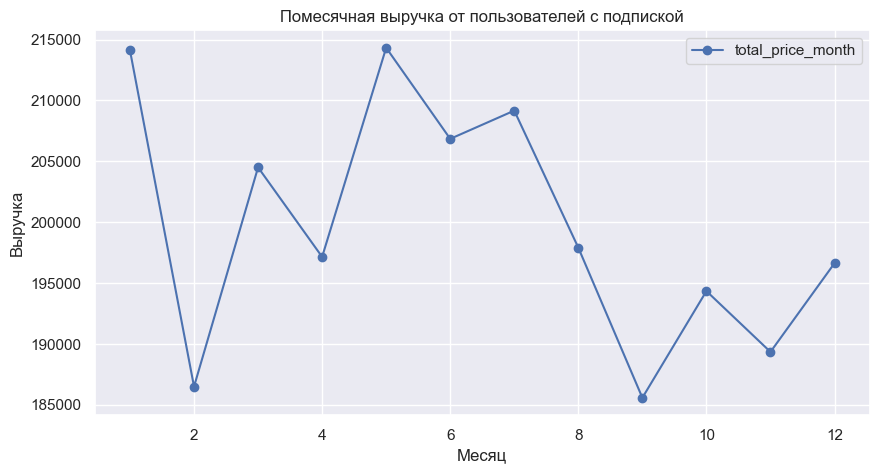

In [24]:
# Считаем выручку от пользователей с подпиской за 2021 год
print('Помесячная выручка от пользователей с подпиской за 2021 год:', agg_df.query('subscription_type == "ultra"')['total_price_month'].sum())
# Зависимость выручки пользователей с подпиской от месяца
agg_df.query('subscription_type == "ultra"').pivot_table(index='month', values='total_price_month', aggfunc='sum').plot(grid=True, style='o-', figsize=(10, 5))
plt.title('Помесячная выручка от пользователей с подпиской')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

Помесячная выручка от пользователей без подписки за 2021 год: 1586236.0


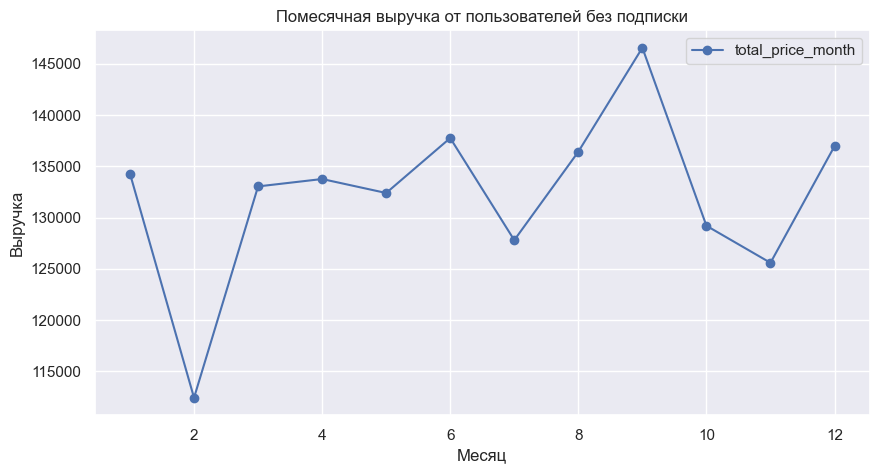

In [25]:
# Считаем выручку от пользователей без подписки за 2021 год
print('Помесячная выручка от пользователей без подписки за 2021 год:', agg_df.query('subscription_type == "free"')['total_price_month'].sum())
# Зависимость выручки пользователей без подписки от месяца
agg_df.query('subscription_type == "free"').pivot_table(index='month', values='total_price_month', aggfunc='sum').plot(grid=True, style='o-', figsize=(10, 5))
plt.title('Помесячная выручка от пользователей без подписки')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

**Вывод**

Исходя  из анализа общей выручки и выручки отдельных групп пользователей с подпиской и пользователей без подписки , можно сказать, что наиболее высокую выручку сервис получает в теплое время года с марта по сентябрь. А также:
* выручка  от пользователей с подпиской за 2021 год выше чем от пользователей без подписки за этот же год
* таже можно заметить что в декабре и январе тоже была высокая выручка. Возможно это влияние южных регионов выборки, т.к. данные регионы не обладают повышенной заснеженностью, пользователи могут передвигаться на самокатах без трудностей.

## Проверка гипотез

### Проверка гипотезы №1

Для проверки гипотезы о том, тратят ли пользователи с подпиской больше времени на поездки, можно использовать двухвыборочный t-тест. Проверим, есть ли значимая разница между средней продолжительностью сессии у пользователей с подпиской и пользователей без подписки.

H0: Среднее время поездки у пользователей с подпиской  равно среднему времени пользователей без подписки\
H1: Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки

In [26]:
# пользователи с подпиской
group_ultra = df_ultra['duration']

# пользователи без подписки
group_free = df_free['duration']

alpha = 0.05 # уровень значимости

# Проведение двухвыборочного t-теста
results = st.ttest_ind(group_ultra, group_free, alternative='greater', equal_var=False)

display(f'p-value: {results.pvalue}')
# Проверка значимости различия между средними значениями
if results.pvalue < alpha:
    print('Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки')
else:
    print('Среднее время поездки у пользователей с подпиской  равно среднему времени пользователей без подписки')

'p-value: 1.1814679253701353e-36'

Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки


### Проверка гипотезы №2

Для проверки гипотезы о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, можно использовать одновыборочный t-тест. Проверим, есть ли значимая разница между средним расстоянием пользователей с подпиской и заданным значением 3130 метров.

H0: Пользователи с подпиской в среднем проезжают расстояние равное оптимальному\
H1: Пользователи с подпиской в среднем не привышают оптимальное расстояние

In [27]:
# пользователи с подпиской
group_ultra = df_ultra['distance']

alpha = 0.05 # уровень значимости

results = st.ttest_1samp(group_ultra, 3130, alternative = 'greater')

display(f'p-value: {results.pvalue}')

# Проверка значимости различия между средним значением и заданным значением
if results.pvalue < alpha:
    print('Пользователи с подпиской в среднем проезжают расстояние больше оптимального')
else:
    print('Пользователи с подпиской в среднем не привышают оптимальное расстояние')

'p-value: 0.9195362605842414'

Пользователи с подпиской в среднем не привышают оптимальное расстояние


### Проверка гипотезы №3

Для проверки гипотезы о том, что помесячная выручка от пользователей с подпиской выше используем одновыборочный t-тест.  Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

H0: Среднемесячная выручка от пользователей с подпиской выше\
H1: Среднемесячная выручка подписчиков не превышает среднемесячную выручку пользователей без подписки

In [28]:
# выручка от пользователей с подпиской
group_ultra = agg_df.query('subscription_type == "ultra"')

# выручка от пользователей без подписки
group_free = agg_df.query('subscription_type == "free"')

alpha = 0.05

# проводим t-тест для независимых выборок
results = st.ttest_ind(group_ultra['total_price_month'], group_free['total_price_month'], alternative='greater')

display(f'p-value: {results.pvalue}')
# выводим полученные результаты
if results.pvalue < alpha:
    print('Среднемесячная выручка от пользователей с подпиской выше')
else:
    print('Среднемесячная выручка подписчиков не превышает среднемесячную выручку пользователей без подписки')

'p-value: 1.318341752391833e-51'

Среднемесячная выручка от пользователей с подпиской выше


## Распределения

###  Акция с раздачей промокодов

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Минимальное количество промокодов: 1161
Вероятность не выполнить план: 4.976%


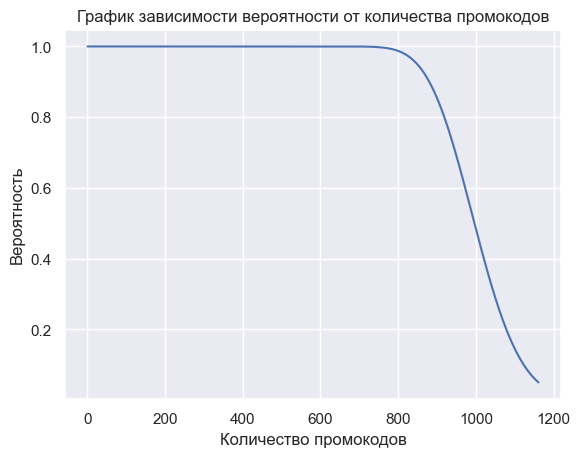

In [29]:
p_ren = 0.1      # вероятность продления подписки
n_clients = 100  # количество клиентов

# подбор параметра n
n = 1
while binom.cdf(n_clients - 1, n, p_ren) > 0.05:
    n += 1

print('Минимальное количество промокодов:', n)
print(f'Вероятность не выполнить план: {binom.cdf(n_clients - 1, n, p_ren):.3%}')

# строим график
x = range(1, n+1)
y = [binom.cdf(n_clients - 1, k, p_ren) for k in x]

plt.plot(x, y)
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность')
plt.title('График зависимости вероятности от количества промокодов')
plt.show()

### Рассылка push-уведомления клиентам

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность открытия не более 399,5 тыс. пользователей: 15.372%


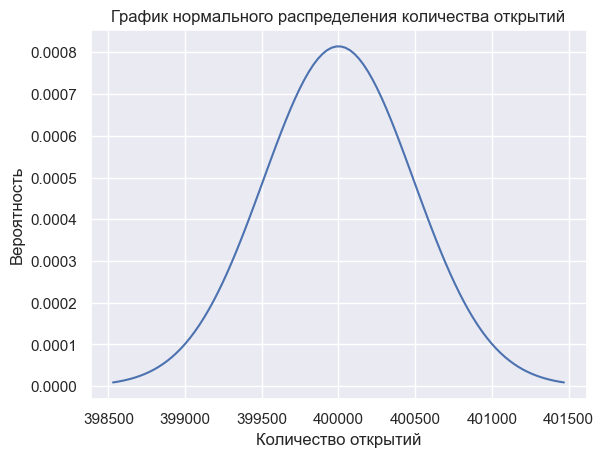

In [30]:
# задаем параметры биноминального распределения
n = 1000000
p = 0.4
# задаем параметры нормального распределения
mu = n * p
# задаем нормальное распределения
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

result = distr.cdf(399500)

print(f'Вероятность открытия не более 399,5 тыс. пользователей: {result:.3%}')

# строим график
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = distr.pdf(x)

plt.plot(x, y)
plt.xlabel('Количество открытий')
plt.ylabel('Вероятность')
plt.title('График нормального распределения количества открытий')
plt.show()

## Вывод

Были получены 3 датаврейма с данными пользователей сервиса аренды самокатов GoFast.\
В процессе обработки было выявлено:
* данные представлены за период 2021 года
* пропусков данных и аномалий не выявлено
* устранены задублированные строки

На этапе исследовательского анализа были изучены следующие данные и получены выводы:
* **частота встречаемости городов:**
   * наиболее активно сервисом пользуются в Пятигорске более 200 пользователей. Наименьший показатель в Москве - 168 пользователя
* **соотношение пользователей с подпиской и без подписки:**
   * доля пользователей без подписки по отношению к пользователям с подпиской выше на 9%
* **возраст пользователей:**
   * 25% пользователей сервиса возрастом около 22 лет
   * 50% пользователей сервиса возрастом около 25 лет
   * 75% пользователей сервиса возрастом около 28 лет
   * средний возраст пользователей около 25 лет
* **расстояние, которое пользователь преодолел за одну поездку:**
   * 25% пользователей сервиса проезжают около 2543 метров
   * 50% пользователей сервиса проезжают около 3133 метров
   * 75% пользователей сервиса проезжают около 3776 метров
   * среднее расстояние, которое проезжает пользователь 3070 метров
* **продолжительность поездок:**
   * у 25% пользователей сервиса продолжительность поездки занимает около 13 минут
   * у 50% пользователей сервиса продолжительность поездки занимает около 17 минут
   * у 75% пользователей сервиса продолжительность поездки занимает около 21 минут
   * средняя продолжительность поездки пользователей около 17 минут

Также данные были разделены по группам:
* пользователи с подпиской - **ultra**
* пользователи без подписки - **free**
На основании групп были проанализированы продолжительность поездок и расстояние, которое пользователь преодолел за одну поездку:
* **расстояние, которое пользователь преодолел за одну поездку:**
   * **ultra**:
      * 25% пользователей сервиса с подпиской проезжают около 2785 метров
      * 50% пользователей сервиса с подпиской проезжают около 3148 метров
      * 75% пользователей сервиса с подпиской проезжают около 3560 метров
      * среднее расстояние, которое проезжает пользователь с подпиской 3115 метров
   * **free**:
      * 25% пользователей сервиса без подписки проезжают около 2366 метров
      * 50% пользователей сервиса без подписки проезжают около 3114 метров
      * 75% пользователей сервиса без подписки проезжают около 3905 метров
      * среднее расстояние, которое проезжает пользователь без подписки 3045 метров

* **продолжительность поездок:**
  * **ultra**:
      * у 25% пользователей сервиса с подпиской продолжительность поездки занимает около 15 минут
      * у 50% пользователей сервиса с подпиской продолжительность поездки занимает около 19 минут
      * у 75% пользователей сервиса с подпиской продолжительность поездки занимает около 22 минут
      * средняя продолжительность поездки пользователей с подпиской около 19 минут
  * **free**:
      * у 25% пользователей сервиса без подписки продолжительность поездки занимает около 13 минут
      * у 50% пользователей сервиса без подписки продолжительность поездки занимает около 18 минут
      * у 75% пользователей сервиса без подписки продолжительность поездки занимает около 22 минут
      * средняя продолжительность поездки пользователей без подписки около 17.8 минут

Исходя  из анализа расстояния и продолжительности поездок пользователей с подпиской и без подписки, можно сказать:
* пользователи без подписки проезжают меньшее расстояние, чем пользователи с подпиской
* у пользователей без подписки продолжительность поездки меньше, чем у пользователей с подпиской

Также была расчитана и изучена общая и помесячная выручка за период 2021 года:
* общая выручка за 2021 год: **3982632.0 руб.**
* помесячная выручка от пользователей с подпиской за 2021 год: **2396396.0 руб.**
* помесячная выручка от пользователей без подписки за 2021 год: **1586236.0 руб**

Исходя  из анализа общей выручки и выручки отдельных групп пользователей с подпиской и пользователей без подписки , можно сказать, что наиболее высокую выручку сервис получает в теплое время года с марта по сентябрь. А также:
* выручка  от пользователей с подпиской за 2021 год выше чем от пользователей без подписки за этот же год
* таже можно заметить что в декабре и январе тоже была высокая выручка. Возможно это влияние южного региона выборки, т.к. данные регионы не обладают повышенной заснеженностью, пользователи могут передвигаться на самокатах без трудностей.

На основе этих данных были проверены и подтверждены следующие гипотезы:\
* среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки
* пользователи с подпиской в среднем не привышают расстояние  3130 метров
* среднемесячная выручка от пользователей с подпиской выше

Были решины 2 задачи,  поставленные отделом маркетинга:
* Выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.\
   **Результат:**\
   Минимальное количество промокодов: 1161 шт.\
   Вероятность не выполнить план: 4.976%
* Оценить вероятность того, что push-уведомление откроют не более 399,5 тыс. пользователей\
   **Результат:**\
   Вероятность открытия не более 399,5 тыс. пользователей: 15.372%


На основании общего анализа пользователей сервиса аренды самокатов GoFast, можно сказать, что существует разница в расстоянии, продолжительности и средней выручки между пользователями с подпиской и без подписки. Выручка пользователей с подпиской выше.\
С целью повышения доходности сервиса можно рассмотреть два варианта:
* можно разослать 1 млн. клиентов push-уведомления в мобильном приложении, тогда вероятность того, что уведомление откроют более 399,5 тыс. пользователей составит около 85%
* провести акцию с раздачей не менее 1161 промокода на один бесплатный месяц подписки, с вероятностью продления подписки около 95%.